# Creating Helper Functions

In [6]:
from tensorflow.keras.optimizers import Adam
#from keras.optimizers_v1 import Adam
from keras.layers import Dense, Dropout, Input, LeakyReLU, Activation
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity

In [7]:
# define helper functions
def kde2D_visualisation(x1, y1, x2, y2, bandwidth, xbins=100j, ybins=100j, min_=0, max_=10, **kwargs):
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[min_:max_:xbins,
             min_:max_:ybins]
    print(xx.shape)

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train = np.vstack([y1, x1]).T
    xy_test = np.vstack([y2, x2]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z_grid = np.exp(kde_skl.score_samples(xy_sample))
    z_test = np.exp(kde_skl.score_samples(xy_test))
    return xx, yy, np.reshape(z_grid, xx.shape), z_test.ravel()

In [8]:
def kde2D(X_train, X_val, bandwidth, **kwargs):
    """Build 2D kernel density estimate (KDE)."""

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(X_train)

    # score_samples() returns the log-likelihood of the samples
    z_val = kde_skl.score_samples(X_val)
    return kde_skl, z_val.ravel()

In [9]:
def kde2D_scores(X, model):
    """Scores based on conformal prediction and 2D kernel density estimate (KDE)."""
    # score_samples() returns the log-likelihood of the samples
    scores = model.score_samples(X).ravel().tolist()

    return scores

In [10]:
def kde2D_pred(X, t_0, t_1, scores_0, scores_1):
    """Predictions based on conformal prediction and 2D kernel density estimate (KDE)."""
    preds = dict()

    # score_samples() returns the log-likelihood of the samples

    for i in range(0, len(X)):
        preds[i] = list()
        if scores_0[i] >= t_0:
            preds[i].append(0)
        if scores_1[i] >= t_1:
            preds[i].append(1)
    return preds


In [11]:
def cp_plots(df_results, name, model):
    texte = model + " Model"
    title_axis = r'$\epsilon$' + ' Values'
    title_acc = 'Accuracy per ' + r'$\epsilon$' + ' Values for ' + name
    title_per = 'Percentages per ' + r'$\epsilon$' + ' Values for ' + name

    df_percentages = df_results[
        ["{0,1} Percentage", "Null Percentage", "Conformal Accuracy With {0,1}"]].copy().sort_index()

    axis = df_percentages.index.values

    plt.rcParams.update({'font.size': 13})
    plt.plot(axis, df_percentages[["{0,1} Percentage"]], color='#2b83ba',
             linestyle='-', linewidth=2, label="{0,1} Set")
    plt.plot(axis, df_percentages[["Null Percentage"]], color='#abdda4',
             linestyle='--', linewidth=2, label="Empty Set")
    plt.legend()
    plt.xlabel(title_axis)
    plt.ylabel("Percentage")

    plt.title(title_per)
    plt.legend(loc="upper right")
    plt.xticks(ticks=[10 * i for i in range(6)])

    plt.savefig('Percentages_eng_%s.eps'%name, format='eps')
    plt.show()

    df_accuracies = df_results[["Valid Conformal Prediction Accuracy",
                                "Valid CNN Accuracy", "CNN Accuracy"]].copy().sort_index()

    axis = df_accuracies.index.values

    plt.rcParams.update({'font.size': 13})
    plt.plot(axis, df_accuracies[["Valid Conformal Prediction Accuracy"]], color='#d7191c',
             linestyle='-', linewidth=2, label="Valid Conformal Model")
    plt.plot(axis, df_accuracies[["Valid CNN Accuracy"]], color='#fdae61',
             linestyle='--', linewidth=2, label= "Valid " + texte)
    plt.plot(axis, df_accuracies[["CNN Accuracy"]], color='#2b83ba',
             linestyle='-.', linewidth=2, label=texte)
    plt.legend()
    plt.xlabel(title_axis)
    plt.ylabel("Accuracy")

    plt.title(title_acc)
    plt.legend(loc="best")
    plt.xticks(ticks=[10 * i for i in range(6)])

    plt.savefig('Accuracies_eng_%s.eps'%name, format='eps')
    plt.show()

In [12]:
def calculate_accuracy(df_test, test_labels, test_mlp_pred, test_pred):
    nbr_all = df_test.shape[0]
    valid_cp = []
    nbr_valid_cnn = 0
    nbr_cp_01 = 0
    nbr_null = 0
    nbr_01 = 0
    labels = test_labels
    df_test = pd.DataFrame()
    df_test["c_pred"] = test_pred.values()
    df_test.index = labels.index
    c_preds = df_test["c_pred"]

    for i in labels.index:
        if labels[i] in c_preds[i]:
            nbr_cp_01 += 1
            if len(c_preds[i]) == 1:
                valid_cp.append(1)
                if test_mlp_pred[i] == labels[i]:
                    nbr_valid_cnn += 1
            else:
                if len(c_preds[i]) > 1:
                    nbr_01 += 1
        else:
            if len(c_preds[i]) == 0:
                nbr_null += 1
            if len(c_preds[i]) == 1:
                valid_cp.append(0)
                if test_mlp_pred[i] == labels[i]:
                    nbr_valid_cnn += 1

    cp_01_acc = nbr_cp_01 / nbr_all
    valid_cp_acc = np.mean(valid_cp)
    valid_cnn_acc = nbr_valid_cnn / len(valid_cp)
    percentage_null = nbr_null / nbr_all * 100
    percentage_01 = nbr_01 / nbr_all * 100

    return (valid_cp_acc, valid_cnn_acc, cp_01_acc, percentage_null, percentage_01)

In [13]:
def prepare_data_visualisation(df_train, df_test):
    label_train = df_train["label"]
    label_test = df_test["label"]
    X_train = df_train["repr"]
    X_test = df_test["repr"]

    X_train = pd.DataFrame(X_train.tolist(), index=X_train.index)
    X_test = pd.DataFrame(X_test.tolist(), index=X_test.index)

    X_train, X_val, label_train, label_val = train_test_split(X_train, label_train, test_size=0.1, random_state=1337,
                                                          stratify=label_train)

    pca = PCA(n_components=2)

    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)

    X_train = (X_train-mean)/std
    X_val = (X_val-mean)/std
    X_test = (X_test-mean)/std

    inertie = pca.explained_variance_ratio_
    return(X_train, label_train, X_val, label_val, X_test, label_test, inertie)

In [14]:
def get_model(n_classes=1, lr=0.00001):
    input_layer = Input((13,))

    # Keras model with two hidden layer with 10 neurons each
    x = Dense(128, name="dense_1")(input_layer)
    x = LeakyReLU()(x)
    x = Dense(50, name="dense_2")(x)
    x_repr = LeakyReLU()(x)
    x = Dropout(0.2)(x_repr)

    if n_classes == 1:
        x = Dense(n_classes, activation="sigmoid", name='out')(x)
    else:
        x = Dense(n_classes, activation="softmax", name='out_multi')(x)

    base_model = Model(input_layer, x, name="base_model")
    repr_model = Model(input_layer, [x, x_repr], name="repr_model")
    if n_classes == 1:
        base_model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(lr))
        repr_model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(lr))

    else:
        base_model.compile(loss="sparse_categorical_crossentropy", metrics=['acc'], optimizer=Adam(lr))
        repr_model.compile(loss="sparse_categorical_crossentropy", metrics=['acc'], optimizer=Adam(lr))

    base_model.summary()
    return base_model, repr_model

# MLP Model

In [16]:
import pandas as pd
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [28]:
if __name__ == "__main__":

    data = pd.read_csv("https://raw.githubusercontent.com/rahvis/CECS550/main/dataset/heart.csv", header=0)
    #data = shuffle(data, random_state=2)
    # shuffle the DataFrame rows
    data = data.sample(frac = 1)

    #data = data.replace("unstable", 0)
    #data = data.replace("stable", 1)
    #data = data.drop("stab", axis=1)

    Y = data["target"]
    X = data.drop("target", axis=1)
    X = (X - X.mean()) / X.std()

    print(X.shape)

    train_data, test_data , train_label, test_label = train_test_split(X, Y, test_size=0.2,
                                                                     random_state=1337, stratify = Y)

    train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size=0.1,
                                                                      random_state=1337, stratify=train_label)

    val = [val_data, val_label]

    file_path = "heart.h5"

    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    early = EarlyStopping(monitor="val_acc", mode="max", patience=10)

    reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=3)

    callbacks_list = [checkpoint, early, reduce_on_plateau]  # early

    model, repr_model = get_model(n_classes=1, lr=0.01)

    model.fit(x=train_data, y=train_label, validation_data=val, epochs=10, verbose=2, callbacks=callbacks_list)


(303, 13)
Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1792      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                6450      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 50)                0         
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 out (Dense)                 (None, 1)        

# MLP Model Prediction

In [18]:
import pandas as pd
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os, shutil

In [19]:
if __name__ == "__main__":
    output_path = "json"
    if os.path.exists(output_path):
        shutil.rmtree(output_path)

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    data = pd.read_csv("heart.csv", header=0)

    #data = data.replace("unstable", 0)
    #data = data.replace("stable", 1)
    #data = data.drop("stab", axis=1)

    Y = data["target"]
    X = data.drop("target", axis=1)
    X = (X - X.mean()) / X.std()

    print(X.shape)

    train_data, test_data , train_label, test_label = train_test_split(X, Y, test_size=0.2,
                                                                     random_state=1337, stratify = Y)

    train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size=0.1,
                                                                      random_state=1337, stratify=train_label)

    file_path = "heart.h5"

    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    early = EarlyStopping(monitor="val_acc", mode="max", patience=10)

    reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=3)

    callbacks_list = [checkpoint, early, reduce_on_plateau]  # early

    model, repr_model = get_model(n_classes=1)

    model.load_weights(file_path)
    repr_model.load_weights(file_path, by_name=True)

    # train data
    pred_train = model.predict(train_data)
    pr, repr_train = repr_model.predict(train_data)

    mlp_preds = list()
    mlp_repr = list()
    for i in range(len(pred_train)):
        mlp_preds.append(pred_train[i][0])
        mlp_repr.append(repr_train[i])

    df = pd.DataFrame({"preds": mlp_preds, "repr": mlp_repr, "label": train_label})
    df.to_json(output_path + "\\heart_train_results.json", orient='records')

    pred = model.predict(test_data)
    pr, repr = repr_model.predict(test_data)

    mlp_preds = list()
    mlp_repr = list()
    for i in range(len(pred)):
        mlp_preds.append(pred[i][0])
        mlp_repr.append(repr[i])

    df = pd.DataFrame({"preds": mlp_preds, "repr": mlp_repr, "label": test_label})
    df.to_json(output_path + "\\heart_test_results.json", orient='records')

    pred = model.predict(val_data)
    pr, repr = repr_model.predict(val_data)

    mlp_preds = list()
    mlp_repr = list()
    for i in range(len(pred)):
        mlp_preds.append(pred[i][0])
        mlp_repr.append(repr[i])

    df = pd.DataFrame({"preds": mlp_preds, "repr": mlp_repr, "label": val_label})
    df.to_json(output_path + "\\heart_val_results.json", orient='records')


(303, 13)
Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1792      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                6450      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 50)                0         
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 out (Dense)                 (None, 1)        

# Conformal

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

training 0 complete
training 1 complete
Scores Calculation complete
0.0
Prediction complete
Calculations done
0.01
Prediction complete
Calculations done
0.02
Prediction complete
Calculations done
0.03
Prediction complete
Calculations done
0.04
Prediction complete
Calculations done
0.05
Prediction complete
Calculations done
0.06
Prediction complete
Calculations done
0.07
Prediction complete
Calculations done
0.08
Prediction complete
Calculations done
0.09
Prediction complete
Calculations done
0.1
Prediction complete
Calculations done
0.11
Prediction complete
Calculations done
0.12
Prediction complete
Calculations done
0.13
Prediction complete
Calculations done
0.14
Prediction complete
Calculations done
0.15
Prediction complete
Calculations done
0.16
Prediction complete
Calculations done
0.17
Prediction complete
Calculations done
0.18
Prediction complete
Calculations done
0.19
Prediction complete
Calculations done
0.2
Prediction complete
Calculations done
0.21
Prediction complete
Calcula

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


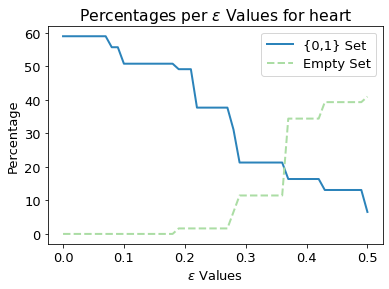

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


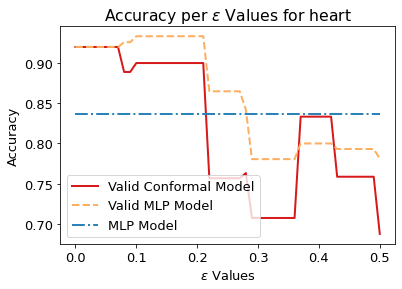

In [21]:
# Read training and testing data
df_train = pd.read_json("json\\heart_train_results.json")
df_test = pd.read_json("json\\heart_test_results.json")
df_val = pd.read_json("json\\heart_val_results.json")

df_train["preds"] = df_train["preds"].apply(lambda x: 0 if x <= 0.5 else 1)
df_test["preds"] = df_test["preds"].apply(lambda x: 0 if x <= 0.5 else 1)
df_val["preds"] = df_val["preds"].apply(lambda x: 0 if x <= 0.5 else 1)

train_labels = df_train["label"]
df_train = df_train.drop("label", axis=1)

val_labels = df_val["label"]
df_val = df_val.drop("label", axis=1)

# select X & Y for each dataset
classes = [0, 1]
nbr_all = df_test.shape[0]

alphas_results = dict()

alphas = [0.01*i for i in range(51)]

train_repr = df_train["repr"]
train_mlp_pred = df_train["preds"]

val_repr = df_val["repr"]
val_mlp_pred = df_val["preds"]

test_repr = df_test["repr"]
test_mlp_pred = df_test["preds"]
test_labels = df_test["label"]

X_train_0 = np.array(train_repr[train_labels == 0].tolist())
X_val_0 = np.array(val_repr[val_labels == 0].tolist())

X_train_1 = np.array(train_repr[train_labels == 1].tolist())
X_val_1 = np.array(val_repr[val_labels == 1].tolist())

X_test = np.array(test_repr.tolist())

model_0, z_val_0 = kde2D(X_train_0, X_val_0, 1)
print("training 0 complete")
scores_0 = z_val_0.ravel().tolist()
sorted_scores_0 = sorted(scores_0)

model_1, z_val_1 = kde2D(X_train_1, X_val_1, 1)
print("training 1 complete")
scores_1 = z_val_1.ravel().tolist()
sorted_scores_1 = sorted(scores_1)

scores_00 = kde2D_scores(X_test, model_0)
scores_01 = kde2D_scores(X_test, model_1)

print("Scores Calculation complete")

cnn = accuracy_score(test_labels,test_mlp_pred)

for alpha in alphas:
    print(alpha)
    t_0 = sorted_scores_0[int(alpha * len(sorted_scores_0))]
    t_1 = sorted_scores_1[int(alpha * len(sorted_scores_1))]

    test_pred = kde2D_pred(X_test, t_0, t_1, scores_00, scores_01)
    print("Prediction complete")

    valid_cp_acc, valid_cnn_acc, cp_01_acc, percentage_null, percentage_01 = \
        calculate_accuracy(df_test, test_labels, test_mlp_pred, test_pred)

    alphas_results[alpha] = [cnn, valid_cp_acc, valid_cnn_acc,
                             cp_01_acc, percentage_null, percentage_01]
    print("Calculations done")

alphas_results_df = pd.DataFrame.from_dict(
    data=alphas_results, orient='index',
    columns=["CNN Accuracy", "Valid Conformal Prediction Accuracy", "Valid CNN Accuracy",
             "Conformal Accuracy With {0,1}", "Null Percentage", "{0,1} Percentage"])
print(alphas_results_df)
alphas_results_df.to_json("json\\heart_alphas_results.json")
df_results = pd.read_json("json\\heart_alphas_results.json", convert_axes=False)

cp_plots(df_results, "heart", "MLP")


# Conformal Visualisation

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# Read training and testing data
df_train = pd.read_json("json\\heart_train_results.json")
df_test = pd.read_json("json\\heart_test_results.json")


X_train, label_train, X_val, label_val, X_test, label_test, inertie = prepare_data_visualisation(df_train, df_test)

density_values = dict()
classes = [0, 1]

for i in classes:
    X_train_class = X_train[label_train == i, :]
    X_val_class = X_val[label_val == i, :]
    X_test_class = X_test[label_test == i, :]

    feature_train_1 = X_train_class[:, 0]
    feature_train_2 = X_train_class[:, 1]

    feature_val_1 = X_val_class[:, 0]
    feature_val_2 = X_val_class[:, 1]

    feature_test_1 = X_test_class[:, 0]
    feature_test_2 = X_test_class[:, 1]

    xx, yy, zz, z_val = kde2D_visualisation(feature_train_1, feature_train_2, feature_val_1, feature_val_2, 0.1,
                                             min_=np.min(X_val) - 0.2, max_=np.max(X_val) + 0.2)

    xx, yy, zz, z_test = kde2D_visualisation(feature_train_1, feature_train_2, feature_test_1, feature_test_2, 0.1,
                                             min_=np.min(X_train) - 0.2, max_=np.max(X_train) + 0.2)
    scores = z_val.ravel().tolist()
    scores.sort()
    t = scores[(1 * len(scores) // 10)]
    print("t : ", t)
    plt.figure()
    zz_bis = np.where(zz > t, 1, 0)
    density_values[i] = [xx, yy, zz_bis, feature_test_1, feature_test_2]

zz_0, zz_1 = density_values[0][2], density_values[1][2]
xx, yy = density_values[0][0], density_values[0][1]

zz = zz_0.copy()

zz[zz_0>0] = -1
zz[zz_1>0] = 2
zz[np.logical_and(zz_0>0,zz_1>0)] = 1

print(zz.shape)

plt.figure()
plt.rcParams.update({'font.size': 13})
plt.contourf(xx, yy, zz, alpha=0.4, levels=[-2, -1, 0, 1, 2], colors=('lightcoral', 'w', 'yellowgreen',
                                                                      'cornflowerblue'))

subset_idx_0 = np.random.choice(range(len(density_values[0][3])), size=3000)
subset_idx_1 = np.random.choice(range(len(density_values[1][3])), size=3000)

plt.scatter(density_values[0][3][subset_idx_0], density_values[0][4][subset_idx_0], c="r", s=1.7,
            alpha=0.4, edgecolors="none", label="Class 0 : Unstable")
plt.scatter(density_values[1][3][subset_idx_1], density_values[1][4][subset_idx_1], c="b", s=1.7,
            alpha=0.4, edgecolors="none", label="Class 1 : Stable")
plt.legend()
plt.xlim(-3, 3)
plt.ylim(-3, 3)
#plt.axis('off')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
title = 'EGSS : ' + r'$\epsilon$' + ' = 0.1'
plt.title(title)

plt.savefig('heart_density_eng.png', format='png')
plt.close()

print(inertie)


(100, 100)
(100, 100)
t :  0.00037558398805898546
(100, 100)
(100, 100)
t :  0.1943435988407388
(100, 100)
[0.77460682 0.06266207]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# Altered Tabluar Data

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [25]:
def random_replace(array, replace_proba=0.2, range=5):
    return [a if np.random.random() > replace_proba else np.random.uniform(-range, range) for a in array]

data = pd.read_csv("heart.csv", header=0)
data_outliers = pd.read_csv("heart.csv", header=0)

#data = data.replace("unstable", 0)
#data = data.replace("stable", 1)
#data = data.drop("stab", axis=1)

Y = data["target"]
X = data.drop("target", axis=1)


data_outliers = data_outliers.replace("unstable", 0)
data_outliers = data_outliers.replace("stable", 1)
#data_outliers = data_outliers.drop("stab", axis=1)

Y_outliers = data_outliers["target"]
X_outliers = data_outliers.drop("target", axis=1)

X_outliers = X_outliers.values.tolist()
_X_outliers = [random_replace(a) for a in X_outliers]
distances = [np.linalg.norm(np.array(a)- np.array(b)) for a, b in zip(X_outliers, _X_outliers)]
X_Y_distance = list(zip(_X_outliers, Y_outliers, distances))
X_Y_distance.sort(key=lambda x: x[2], reverse=True)
X_Y_distance = X_Y_distance[:len(X_Y_distance)//5]

X_outliers = [a[0] for a in X_Y_distance]
Y_outliers = [a[1] for a in X_Y_distance]

X_outliers = np.array(X_outliers)

X_outliers = pd.DataFrame(X_outliers, columns=X.columns)



train_data, test_data, train_label, test_label = train_test_split(X, Y, test_size=0.2,
                                                                  random_state=1337, stratify=Y)
_, X_outliers, _, Y_outliers = train_test_split(X_outliers, Y_outliers, test_size=0.2,
                                                                  random_state=1337, stratify=Y_outliers)

file_path = "heart.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=10)
reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=3)
callbacks_list = [checkpoint, early, reduce_on_plateau]  # early
model, repr_model = get_model(n_classes=1)
model.load_weights(file_path)
repr_model.load_weights(file_path, by_name=True)

# noisy data
mu, sigma = 0, 0.5
# creating a noise with the same dimension as the dataset
noise = np.random.normal(mu, sigma, test_data.shape)
noisy_test_data = test_data + noise

noisy_test_data = (noisy_test_data - X.mean()) / X.std()

pred_noisy = model.predict(noisy_test_data)
pr, repr_noisy = repr_model.predict(noisy_test_data)

mlp_preds_noisy = list()
mlp_repr_noisy = list()
for i in range(len(pred_noisy)):
    mlp_preds_noisy.append(pred_noisy[i][0])
    mlp_repr_noisy.append(repr_noisy[i])

df = pd.DataFrame({"preds": mlp_preds_noisy, "repr": mlp_repr_noisy, "label": test_label})
df.to_json("json\\heart_noisy_results.json", orient='records')


X_outliers = (X_outliers - X.mean()) / X.std()

pred_noisy = model.predict(X_outliers)
pr, repr_noisy = repr_model.predict(X_outliers)

mlp_preds_noisy = list()
mlp_repr_noisy = list()
for i in range(len(pred_noisy)):
    mlp_preds_noisy.append(pred_noisy[i][0])
    mlp_repr_noisy.append(repr_noisy[i])

df = pd.DataFrame({"preds": mlp_preds_noisy, "repr": mlp_repr_noisy, "label": Y_outliers})
df.to_json("json\\heart_outliers_results.json", orient='records')

test_data = (test_data - X.mean()) / X.std()

pred_noisy = model.predict(test_data)
pr, repr_noisy = repr_model.predict(test_data)

mlp_preds_noisy = list()
mlp_repr_noisy = list()
for i in range(len(pred_noisy)):
    mlp_preds_noisy.append(pred_noisy[i][0])
    mlp_repr_noisy.append(repr_noisy[i])

df = pd.DataFrame({"preds": mlp_preds_noisy, "repr": mlp_repr_noisy, "label": test_label})
df.to_json("json\\heart_clean_results.json", orient='records')



Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                6450      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 50)                0         
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 out (Dense)                 (None, 1)                 5

# Conformal Visualisation - Altered Data

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [27]:
def random_replace(array, replace_proba=0.2, range=5):
    return [a if np.random.random() > replace_proba else np.random.uniform(-range, range) for a in array]

data = pd.read_csv("heart.csv", header=0)
data_outliers = pd.read_csv("heart.csv", header=0)

#data = data.replace("unstable", 0)
#data = data.replace("stable", 1)
#data = data.drop("stab", axis=1)

Y = data["target"]
X = data.drop("target", axis=1)


data_outliers = data_outliers.replace("unstable", 0)
data_outliers = data_outliers.replace("stable", 1)
#data_outliers = data_outliers.drop("stab", axis=1)

Y_outliers = data_outliers["target"]
X_outliers = data_outliers.drop("target", axis=1)

X_outliers = X_outliers.values.tolist()
_X_outliers = [random_replace(a) for a in X_outliers]
distances = [np.linalg.norm(np.array(a)- np.array(b)) for a, b in zip(X_outliers, _X_outliers)]
X_Y_distance = list(zip(_X_outliers, Y_outliers, distances))
X_Y_distance.sort(key=lambda x: x[2], reverse=True)
X_Y_distance = X_Y_distance[:len(X_Y_distance)//5]

X_outliers = [a[0] for a in X_Y_distance]
Y_outliers = [a[1] for a in X_Y_distance]

X_outliers = np.array(X_outliers)

X_outliers = pd.DataFrame(X_outliers, columns=X.columns)



train_data, test_data, train_label, test_label = train_test_split(X, Y, test_size=0.2,
                                                                  random_state=1337, stratify=Y)
_, X_outliers, _, Y_outliers = train_test_split(X_outliers, Y_outliers, test_size=0.2,
                                                                  random_state=1337, stratify=Y_outliers)

file_path = "heart.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=10)
reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=3)
callbacks_list = [checkpoint, early, reduce_on_plateau]  # early
model, repr_model = get_model(n_classes=1)
model.load_weights(file_path)
repr_model.load_weights(file_path, by_name=True)

# noisy data
mu, sigma = 0, 0.5
# creating a noise with the same dimension as the dataset
noise = np.random.normal(mu, sigma, test_data.shape)
noisy_test_data = test_data + noise

noisy_test_data = (noisy_test_data - X.mean()) / X.std()

pred_noisy = model.predict(noisy_test_data)
pr, repr_noisy = repr_model.predict(noisy_test_data)

mlp_preds_noisy = list()
mlp_repr_noisy = list()
for i in range(len(pred_noisy)):
    mlp_preds_noisy.append(pred_noisy[i][0])
    mlp_repr_noisy.append(repr_noisy[i])

df = pd.DataFrame({"preds": mlp_preds_noisy, "repr": mlp_repr_noisy, "label": test_label})
df.to_json("json\\heart_noisy_results.json", orient='records')


X_outliers = (X_outliers - X.mean()) / X.std()

pred_noisy = model.predict(X_outliers)
pr, repr_noisy = repr_model.predict(X_outliers)

mlp_preds_noisy = list()
mlp_repr_noisy = list()
for i in range(len(pred_noisy)):
    mlp_preds_noisy.append(pred_noisy[i][0])
    mlp_repr_noisy.append(repr_noisy[i])

df = pd.DataFrame({"preds": mlp_preds_noisy, "repr": mlp_repr_noisy, "label": Y_outliers})
df.to_json("json\\heart_outliers_results.json", orient='records')

test_data = (test_data - X.mean()) / X.std()

pred_noisy = model.predict(test_data)
pr, repr_noisy = repr_model.predict(test_data)

mlp_preds_noisy = list()
mlp_repr_noisy = list()
for i in range(len(pred_noisy)):
    mlp_preds_noisy.append(pred_noisy[i][0])
    mlp_repr_noisy.append(repr_noisy[i])

df = pd.DataFrame({"preds": mlp_preds_noisy, "repr": mlp_repr_noisy, "label": test_label})
df.to_json("json\\heart_clean_results.json", orient='records')

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1792      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                6450      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 50)                0         
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 out (Dense)                 (None, 1)                 5